# Visualizing Weather Data

Load in required packages:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from datetime import datetime
%matplotlib inline

### Step 1. Figure out lat-lon of weather stations

Read in site files from solar radiation data, since these files include all the common sites across temp, precip and solrad, and within the first line include some information of the stie. I'm only reading in files from year 1962, since all sites are present for this year, and just one year will give us all the information needed for each site.

In [48]:
sites = pd.read_table("/home/disk/eos8/ach315/data/ISH_NSRD/station_list_1961to1990.txt", 
                      header= None, squeeze= True, dtype= str)
file_list = sites + "_62.txt" # generate the files from year 1962 to read in

WBAN_id = list()
cities = list()
states = list()
latitude = list()
longitude = list()

for i in file_list:
    solrad_file = pd.read_table('/home/disk/eos8/ach315/data/ISH_NSRD/1961to1990/' + 
                                str(i), squeeze= True, header= None)
    wban = solrad_file[0][1:6]
    WBAN_id.append(wban)
    
    city = solrad_file[0][7:29]
    cities.append(city)
    
    state = solrad_file[0][30:32]
    states.append(state)

    lat_degree = int(solrad_file[0][39:42])
    lat_minute = int(solrad_file[0][42:44])*0.01
    lat = lat_degree + lat_minute
    latitude.append(lat)
    
    lon_degree = int(solrad_file[0][47:50])
    lon_minute = int(solrad_file[0][51:53])*0.01
    lon = lon_degree + lon_minute
    longitude.append(lon)
    
site_info = pd.DataFrame({'site': WBAN_id,
                          'city': cities,
                          'state': states,
                          'lat': latitude,
                          'lon': longitude},
                         columns = ['site', 'city', 'state', 'lat', 'lon'])

site_info.to_csv('/home/disk/eos8/ach315/upscale/weadata/site_info.csv')

### Step 2. Plot out weather station locations on map

In [51]:
site_info = pd.read_csv("/home/disk/eos8/ach315/upscale/weadata/site_info.csv", index_col=0, dtype=str)
site_years = pd.read_csv("/home/disk/eos8/ach315/upscale/weadata/site_years.csv", index_col=0, dtype=str)

In [52]:
df_siteyears = pd.merge(left=site_years, right=site_info, how="inner")
df_siteyears.head()

,site,years,city,state,lat,lon
0,03103,21,FLAGSTAFF,AZ,35.08,111.4
1,03812,20,ASHEVILLE,NC,35.26,82.32
2,03813,21,MACON,GA,32.42,83.39
3,03820,19,AUGUSTA,GA,33.22,81.58
4,03822,20,SAVANNAH,GA,32.08,81.12


In [ ]:
# lat limit: 20, 75
# lon: 190, 305
# eqaconic projection in matlab
# AlbersEqualArea

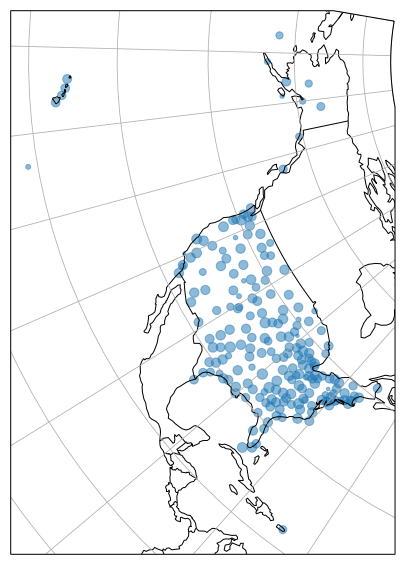

In [104]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.AlbersEqualArea())

ax.scatter(360 - df_siteyears['longitude'], df_siteyears['latitude'], 
           transform=ccrs.PlateCarree(), cmap='magma', 
           s= df_siteyears["years"]*4, alpha= 0.5)

#plt.set_cmap(plt.cm.viridis)
#cbar = plt.colorbar(ax=ax)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.gridlines()
plt.show()

### Step 3. Plot out mean growing season climatology for each site